In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import tqdm
import seaborn as sns

In [2]:
df_list=[]
for filenumber in tqdm.tqdm(range(1,37)):
# Open the .root file
    filePath=f'../36_files/JetNtuple_RunIISummer16_13TeV_MC_{filenumber}.root'
    file = uproot.open(filePath)
# Access the tree structu
    tree = file['AK4jets/jetTree']
# Define the columns you want to read
    columns = ['isPhysG', 'isPhysUDS','QG_mult','QG_ptD','QG_axis2','jetPt','jetEta','jetQGl','jetMass','jetGirth','jetArea','jetChargedHadronMult','jetNeutralHadronMult','jetChargedMult','jetNeutralMult']
    df=tree.arrays(columns, library='pd')
    df_list.append(df)

df=pd.concat(df_list,ignore_index='true')

100%|██████████| 36/36 [00:06<00:00,  5.53it/s]


In [3]:
# First remove all the other types of jets from the data except the gluon and the light quark (UDS) jets
df = df[(df.isPhysG==1) | (df.isPhysUDS==1)].reset_index()
# We keep only jets that either stem from QCD or UDS.
#selecting only a range of pt 
df_pt_ranged=df[(df.jetPt>30) & (df.jetPt<600)]
df_selected=df_pt_ranged

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_selected, test_size=0.2, random_state=42)

train_y = train.isPhysUDS
test_y = test.isPhysUDS
input_features = ['QG_mult','QG_ptD','QG_axis2','jetPt','jetEta','jetMass','jetGirth','jetArea','jetChargedHadronMult','jetNeutralHadronMult']
train_x=train[input_features]
test_x=test[input_features]

In [5]:
from tensorflow.keras.models import load_model

model=load_model('added_var_models/model.h5')

2024-04-22 10:37:42.394409: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 10:37:42.422713: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 10:37:42.422750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 10:37:42.423934: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 10:37:42.429523: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 10:37:42.430341: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [6]:
pred_y_test=model.predict(test_x)
pred_y_train=model.predict(train_x)

  191/60024 [..............................] - ETA: 31s 

2024-04-22 10:37:58.525481: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153659040 exceeds 10% of free system memory.


60024/60024 [==============================] - 36s 594us/step


In [7]:
pred_y_test_q=pred_y_test[test_y==1]
pred_y_test_g=pred_y_test[test_y==0]
pred_y_train_q=pred_y_train[train_y==1]
pred_y_train_g=pred_y_train[train_y==0]


In [8]:
from scipy import stats
stats.ks_2samp(pred_y_test_g, pred_y_train_g )


KstestResult(statistic=array([0.00191691]), pvalue=array([0.29665811]), statistic_location=array([0.25974491]), statistic_sign=array([1.]))

In [9]:
stats.ks_2samp(pred_y_test_q, pred_y_train_q )

KstestResult(statistic=array([0.00202744]), pvalue=array([0.68182226]), statistic_location=array([0.83292514]), statistic_sign=array([1.]))

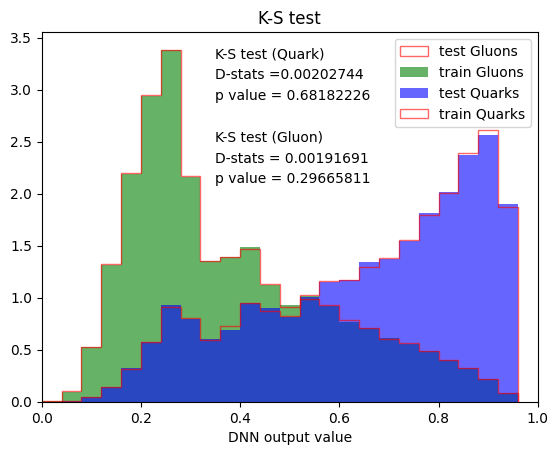

In [10]:
plt.clf()
binnings = np.arange(0.0, 1.0, 0.04)
plt.hist( pred_y_test_g, bins=binnings, alpha=0.6, label="test Gluons", density=1,histtype="step",color='r' )
plt.hist( pred_y_train_g, bins=binnings, alpha=0.6, label="train Gluons", density=1 ,color='g')
plt.hist( pred_y_test_q, bins=binnings, alpha=0.6, label="test Quarks", density=1 ,color='b')
plt.hist( pred_y_train_q, bins=binnings, alpha=0.6, label="train Quarks", density=1,histtype='step',color='r' )
plt.text(0.35,3.3,'K-S test (Quark)')
plt.text(0.35,3.1,'D-stats =0.00202744 ')
plt.text(0.35,2.9,'p value = 0.68182226')
plt.text(0.35,2.5,'K-S test (Gluon)')
plt.text(0.35,2.3,'D-stats = 0.00191691')
plt.text(0.35,2.1,'p value = 0.29665811')


plt.xlim(0,1)
plt.legend()
plt.xlabel('DNN output value')
plt.title('K-S test');